# MCMC Analysis and Plots
This notebook is to analyze MCMC walk data and produce relevant results plots

In [1]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [2]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.

In [3]:
def LindFit_helper(params):
    return np.sum(calcGOF(model='Lind', params=params, bin_low=5, bin_high=101, GOF='chisq'))

In [4]:
#Load the MCMC data
import pickle as pkl

fname='data/mcmc_Lind_8walk_5000step_pois_v1.pkl'
sampler_l=pkl.load(open(fname,'rb'))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


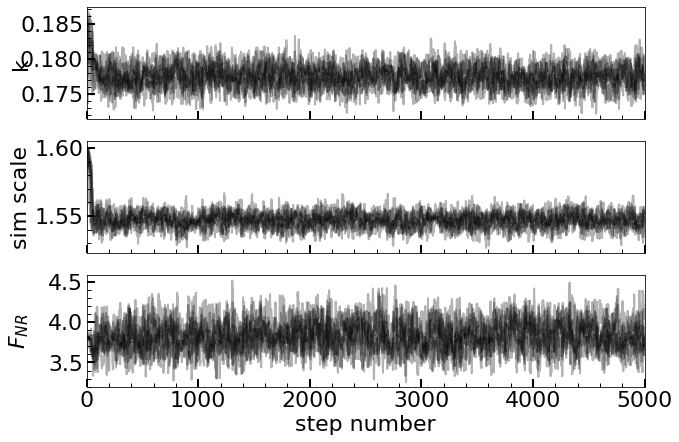

In [5]:
#Look at the chain of parameter values
labels_l = [r'k', r'sim scale', r'$F_{NR}$']

samples_l = sampler_l.get_chain()
ndim_l = samples_l.shape[2]

fig, axes = plt.subplots(ndim_l, figsize=(10, 7), sharex=True)
for i in range(ndim_l):
    ax = axes[i]
    ax.plot(samples_l[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_l))
    #ax.set_ylim(0, 5)
    ax.set_ylabel(labels_l[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [6]:
#Get the sample autocorrelation times for each variable and use the largest one
tau_l=sampler_l.get_autocorr_time()
print(tau_l)
avgtau_l=round(np.max(tau_l))
print(avgtau_l)

[42.73063231 43.67642262 46.96358875]
47.0


In [7]:
#Discard a few times tau as burn-in and thin by tau/2
flat_samples_l = sampler_l.get_chain(discard=int(2.*avgtau_l), thin=int(round(avgtau_l/2.)), flat=True)
print(flat_samples_l.shape)

(1632, 3)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


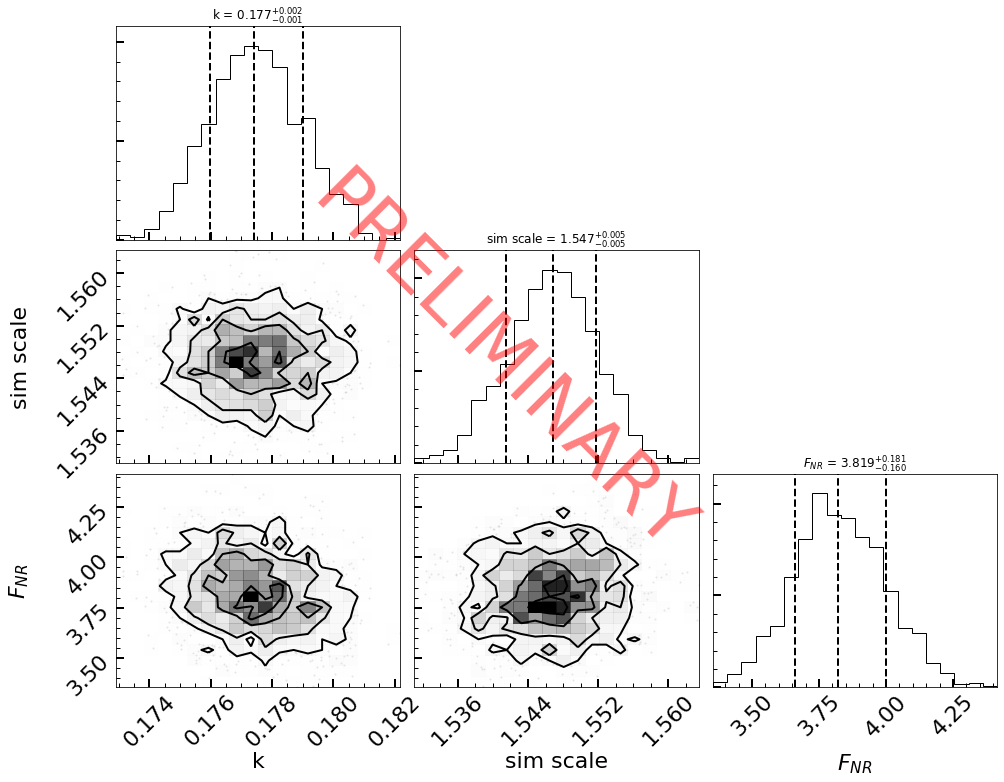

In [8]:
#Make the corner plot
import corner

fig_w=15
fig,ax = plt.subplots(ndim_l,ndim_l,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples_l, labels=labels_l, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f', fig=fig
);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_corner.png')

In [9]:
#Calculate the median and 1-sigma equivalent uncertainties
from IPython.display import display, Math

for i in range(ndim_l):
    mcmc = np.percentile(flat_samples_l[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_l[i])
    txt=txt.replace('$','')
    #print(txt)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
#Get the best fit results
pars=np.zeros(ndim_l)
for i in range(ndim_l):
    pars[i]=np.percentile(flat_samples_l[:, i], 50)
print(pars)

[0.17742274 1.54683436 3.81886954]


# Show best fit spectrum

In [11]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4()
cap=r68.load_simcap()

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
200000


In [12]:
#Energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)


R_meas = N_meas_PuBe/meas['PuBe']['tlive']-N_meas_Bkg/meas['Bkg']['tlive']
dR_meas = np.sqrt( N_meas_PuBe/(meas['PuBe']['tlive']**2) + N_meas_Bkg/(meas['Bkg']['tlive']**2) )

In [13]:
import R68_spec_tools as spec
import R68_yield as Yield
Y=Yield.Yield('Lind',[0.2])

#Lindhard
Y.pars=pars[:1]
F_NR=pars[2]
scale_g4=pars[1]
scale_ng=scale_g4

dict_keys(['xx', 'yy', 'ex', 'ey'])


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


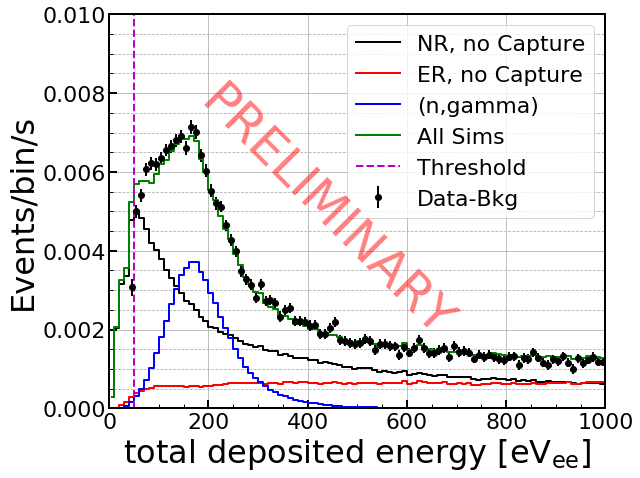

In [14]:
NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5])

plt.gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5)
plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_spectrum.png')

# Yield curve

In [43]:
from scipy.optimize import fsolve
def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


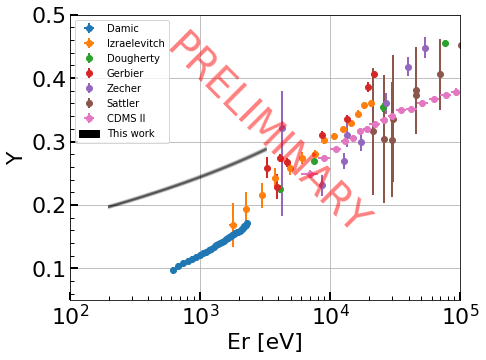

In [16]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches
#Plot best fit yield
Y=Yield.Yield('Lind',[0.2])
Y.pars=pars[:1]

thresh_low_NR=ERtoNR(50,Y,V,eps)
thresh_high_NR=ERtoNR(1000,Y,V,eps)

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))


#TODO: Determine this range
Er_plot=np.linspace(200,3.2e3,100)

#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')

#This work
inds = np.random.randint(len(flat_samples_l), size=100)
for ind in inds:
    thetai = flat_samples_l[ind][0]
    Y=Yield.Yield('Lind',[thetai])
    ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)

#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

#Example Lindhard curves
#Er_full=np.logspace(2,5,100)
#Y=Yield.Yield('Lind',[0.146])
#ax.plot(Er_full, Y.calc(Er_full), '--k')
#Y=Yield.Yield('Chav',[0.15,0.247])
#ax.plot(Er_full, Y.calc(Er_full), '--k')

#Manually add legend entry
handles, labels = ax.get_legend_handles_labels()
patch = mpatches.Patch(color='k', label='This work')
handles.append(patch) 

ax.legend(handles=handles, loc='upper left')

ax.set_xscale('log')
ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
ax.set_xlim(1e2,1e5);
ax.set_ylim(0.05,0.5);
ax.grid()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_compare.png')

How to determine the range over which we trust this yield? Let's also histogram all the Ers at which we evaluated the yield, so  we can see how densely we probed it.

In [17]:
#Direct NRs
evec_nr=g4['NR']['E']
evec_Nnr=g4['NR']['N']

#Select events which end up in the analysis ROI
Eee_nr = np.sum(evec_nr*(1 + Y.calc(evec_nr)*V/eps)/(1+V/eps),1)
evec_nr=evec_nr[(Eee_nr>50) & (Eee_nr<1000)]
evec_Nnr=evec_Nnr[(Eee_nr>50) & (Eee_nr<1000)]

#Separate out singles and multiples
evec_nr_sing=evec_nr[(evec_Nnr==1).flatten()]
evec_nr_mult=evec_nr[(evec_Nnr!=1).flatten()]

#Flatten and remove 0's
evec_nr_sing=evec_nr_sing[evec_nr_sing!=0].flatten()
evec_nr_mult=evec_nr_mult[evec_nr_mult!=0].flatten()

In [18]:
#(n,gamma)
evec_ng=cap['E']
devec_ng=cap['dE']
evec_Nng=cap['N']

#Select events which end up in the analysis ROI
evec_ng_eion = evec_ng*Y.calc(evec_ng) - (evec_ng-devec_ng)*Y.calc(evec_ng-devec_ng)
Eee_ng = np.sum((devec_ng + evec_ng_eion*V/eps)/(1+V/eps),1)
evec_ng=evec_ng[(Eee_ng>50) & (Eee_ng<1000)]
devec_ng=devec_ng[(Eee_ng>50) & (Eee_ng<1000)]
evec_Nng=evec_Nng[(Eee_ng>50) & (Eee_ng<1000)]

#Separate out singles and multiples
evec_ng_sing=evec_ng[(evec_Nng==1).flatten()]
evec_ng_mult=evec_ng[(evec_Nng!=1).flatten()]
#Flatten and remove 0's
evec_ng_sing=evec_ng_sing[evec_ng_sing!=0].flatten()
evec_ng_mult=evec_ng_mult[evec_ng_mult!=0].flatten()

In [19]:
#Make histograms
Emax_Er = 3500 #eVee
Ebins_Er=np.linspace(0,Emax_Er,101)
Ebins_Er_ctr=(Ebins_Er[:-1]+Ebins_Er[1:])/2

n_nr_sing,_=np.histogram(evec_nr_sing, bins=Ebins_Er)
n_nr_mult,_=np.histogram(evec_nr_mult, bins=Ebins_Er)

n_ng_sing,_=np.histogram(evec_ng_sing, bins=Ebins_Er)
n_ng_mult,_=np.histogram(evec_ng_mult, bins=Ebins_Er)

#Adjust for relative livetime
n_nr_sing=n_nr_sing/g4['NR']['tlive']
n_nr_mult=n_nr_mult/g4['NR']['tlive']
n_ng_sing=n_ng_sing/cap['tlive']
n_ng_mult=n_ng_mult/cap['tlive']

#Normalize
n_tot=np.sum(n_nr_sing+n_nr_mult+n_ng_sing+n_ng_mult)
n_nr_sing/=n_tot
n_nr_mult/=n_tot
n_ng_sing/=n_tot
n_ng_mult/=n_tot

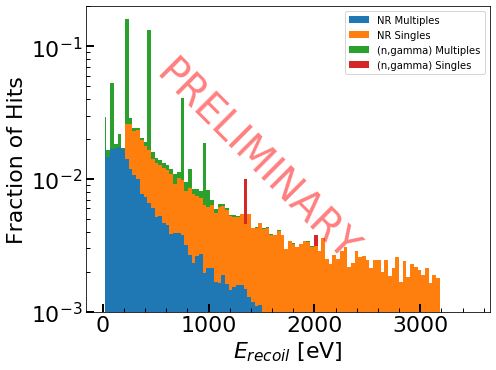

In [20]:
#Draw stacked histogram

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#No relative livetime
#ax.hist([evec_nr_mult, evec_nr_sing, evec_ng_mult, evec_ng_sing], bins=Ebins_Er, stacked=True, density= True, 
#        label=['NR Multiples', 'NR Singles', '(n,gamma) multiples', '(n,g) singles'])

#Relative livetimes, but no shading
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult+n_ng_sing, where='mid', linestyle='-', \
#        label='(n,gamma) Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult, where='mid', linestyle='-', \
#        label='(n,gamma) Multiples', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing, where='mid', linestyle='-', \
#        label='NR Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult, where='mid', linestyle='-', \
#             label='NR Multiples', linewidth=2)


ax.fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Fraction of Hits')
ax.set_ylim(1e-3,2e-1)
ax.legend()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_hits.png')

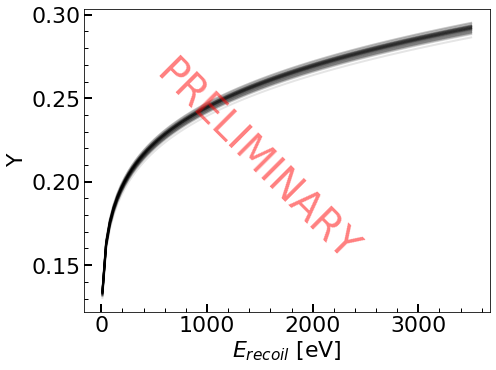

In [21]:
# Just our curve
fig,axs = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

Er_plot=np.linspace(10,3.5e3,100)
inds = np.random.randint(len(flat_samples_l), size=100)
for i,ind in enumerate(inds):
    thetai = flat_samples_l[ind][0]
    Y=Yield.Yield('Lind',[thetai])
    axs.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.05)

axs.set_xlabel(r'$E_{recoil}$ [eV]')
axs.set_ylabel('Y')

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield.png')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


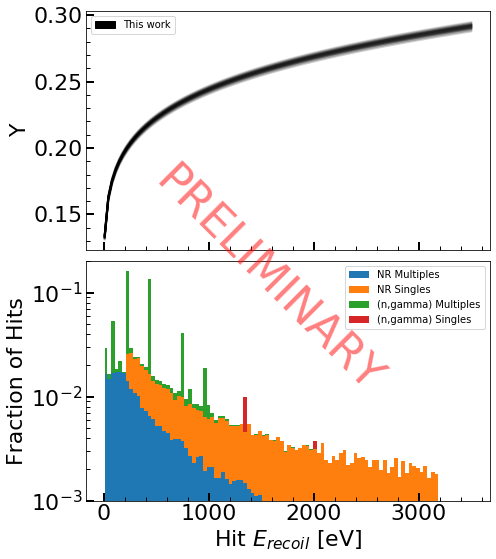

In [22]:
# Combine both plots
fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)), sharex=True)

#TODO: Add other measurements from lit
#pt.plotOldYs(axs[0],fmt='.')

#This work
Er_plot=np.linspace(10,3.5e3,100)
inds = np.random.randint(len(flat_samples_l), size=100)
for i,ind in enumerate(inds):
    thetai = flat_samples_l[ind][0]
    Y=Yield.Yield('Lind',[thetai])
    axs[0].plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.05)

#axs[0].axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#axs[0].axvline(thresh_high_NR, color='m', linestyle='--')

#axs[0].set_xlabel('Er [eV]')
axs[0].set_ylabel('Y')
#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
#ax.set_ylim(0.1,0.3);

#Manually add legend entry
import matplotlib.patches as mpatches
handles, labels = axs[0].get_legend_handles_labels()
patch = mpatches.Patch(color='k', label='This work')
handles.append(patch) 

axs[0].legend(handles=handles, loc='upper left')


fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=45, alpha=0.5)


axs[1].fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

axs[1].set_yscale('log')
axs[1].set_xlabel(r'Hit $E_{recoil}$ [eV]')
axs[1].set_ylabel('Fraction of Hits')
#axs[1].set_xlim(0,5e3)
axs[1].set_ylim(1e-3,2e-1)
axs[1].legend()
plt.tight_layout()

plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_and_hist.png')

In [ ]:
#Combined spectrum plot with hits histogram

NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)

/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


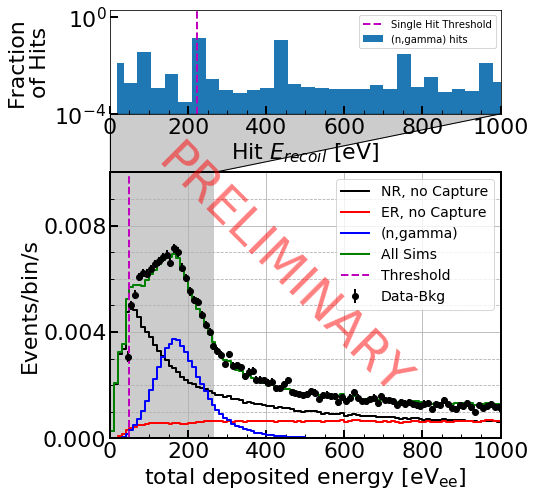

In [137]:
#fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)))

fig = plt.figure(figsize=(fig_w, 1.5*fig_w*(.75)))
gs = fig.add_gridspec(16, 1)
ax0 = fig.add_subplot(gs[:4, :])
ax1 = fig.add_subplot(gs[6:, :])
axs=[ax0,ax1]

#Spectra
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5], axis=axs[1])

axs[1].set_yticks(np.array([0, 4e-3, 8e-3]))
axs[1].set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',{'size':'22'})
axs[1].set_ylabel('Events/bin/s',{'size':'22'})
axs[1].legend(loc=1,prop={'size':14})

#Second NR axis for spectra
Y=Yield.Yield('Lind',pars[:1])

#axs_nr = axs[1].twiny()
#nr_ticks = np.array([0,1e3,2e3,3e3])

#axs_nr.set_xlim(axs[1].get_xlim())
#axs_nr.set_xticks(NRtoER(nr_ticks,Y,V,eps))
#axs_nr.set_xticklabels(nr_ticks.astype(int))

#axs_nr.set_xlabel(r"Modified x-axis: $1/(1+X)$")


#Hit histos
axs[0].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult, step='mid', \
             label='(n,gamma) hits', linewidth=2)

axs[0].axvline(ERtoNR(Ebins[5],Y,V,eps), color='m', linestyle='--', linewidth=2, label='Single Hit Threshold')

axs[0].set_xlabel(r'Hit $E_{recoil}$ [eV]')
#axs[0].set_xlim(0,ERtoNR(axs[1].get_xlim()[1],Y,V,eps))
axs[0].set_xlim(0,1000)

axs[0].set_yscale('log')
axs[0].set_ylabel('Fraction\nof Hits')
axs[0].set_ylim(1e-4,2e0)
axs[0].set_yticks([1e-4,1e0])
axs[0].legend()

#Connect the axis ranges with some lines like a zoom-in
transFigure = fig.transFigure.inverted()

coord_a0 = transFigure.transform(axs[0].transData.transform([0,1e-4]))
coord_a1 = transFigure.transform(axs[1].transData.transform([0,1e-2]))
coord_b0 = transFigure.transform(axs[0].transData.transform([1e3,1e-4]))
coord_b1 = transFigure.transform(axs[1].transData.transform([NRtoER(1e3,Y,V,eps),1e-2]))


line_a = mpl.lines.Line2D((coord_a0[0],coord_a1[0]),(coord_a0[1],coord_a1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
line_b = mpl.lines.Line2D((coord_b0[0],coord_b1[0]),(coord_b0[1],coord_b1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
fig.lines.extend([line_a,line_b])

coords=np.array([coord_a0, coord_a1, coord_b1, coord_b0,])
poly = mpl.patches.Polygon(coords,fill=True, color='k', alpha=0.2, zorder=0,
                                  transform=fig.transFigure, figure=fig)
fig.patches.extend([poly])

axs[1].add_patch(plt.Rectangle((0,0), NRtoER(1e3,Y,V,eps), 1e-2,
                     facecolor='k', alpha=0.2))

fig.text(0.2, 0.2, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);

plt.tight_layout()

plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_spectrum_hits_comp.png', bbox_inches = "tight")